Types of plots:
Boxplot/violinplot
- per class for each model
- average, but models side by side
Wandb
- loss functions evolution
- loss/dice evolution of top models

In [ ]:
!pip install pandas 
!pip install tabulate

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

(1, 1967, 5)
Total nr of valid images: 1967
Heart perfect score image count: 1536
Heart worst score image count: 223


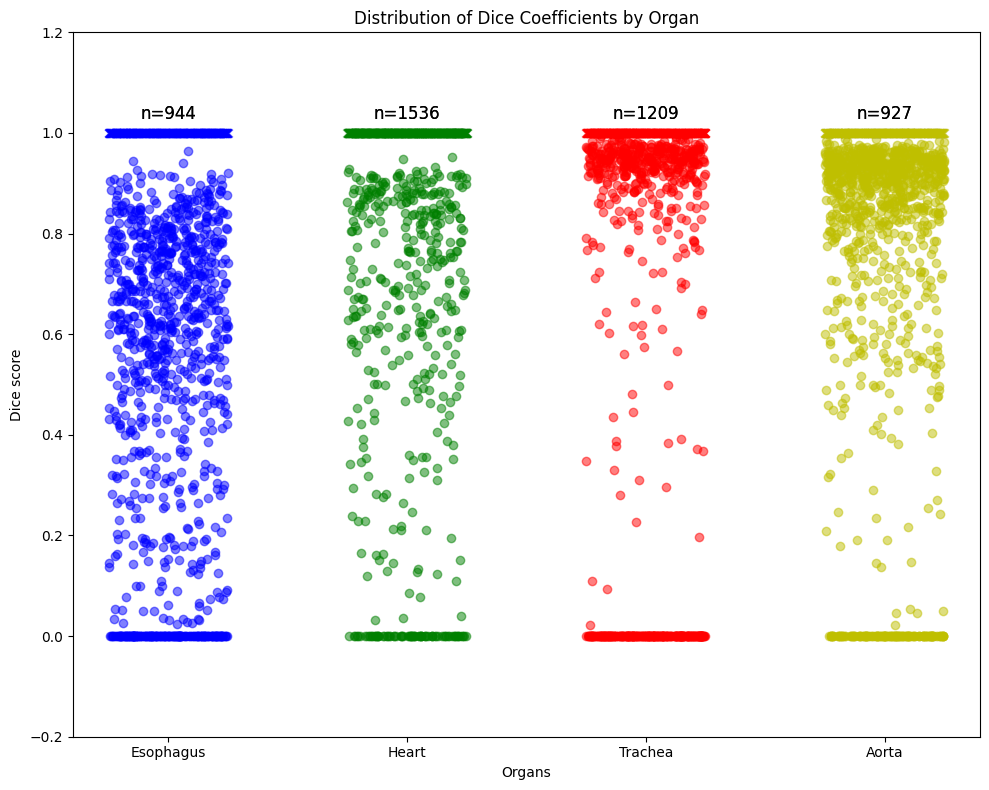

In [6]:
from pathlib import Path

base_path = Path('results/final_results/BASELINES/BASELINE1_ENet')
dice_metrics = np.load(base_path / 'dice_val.npy')
print(dice_metrics.shape)


def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-5, 5, offsets.shape[0])
    # jittered_offsets[:, 1] += np.random.uniform(-0.1, 0.1, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

fig, ax1 = plt.subplots()

fig.set_size_inches(10, 8)
columns = ['Esophagus', 'Heart', 'Trachea', 'Aorta']
colors = ['b', 'g', 'r', 'y']
columns_pos = [10, 30, 50, 70]

all_valid_images = sorted(list(Path(base_path / 'iter000/val').glob('*.png')))
print(f"Total nr of valid images: {len(all_valid_images)}")
nr_esophagus_perfect_score = np.count_nonzero(dice_metrics[0, :, 2] == 1)
print(f"Heart perfect score image count: {nr_esophagus_perfect_score}")
print(f"Heart worst score image count: {np.count_nonzero(dice_metrics[0, :, 1] < 0.1)}")


# c = df_1['Delta_7']

for i, column in enumerate(columns):
    # dots = plt.scatter(np.full((len(metrics[0]), 1), columns_pos[i]), metrics[0, :, i], s=50, c=c, cmap='plasma')
    
    K = i + 1
    # lower_than_1 = dice_metrics[0, :, K][dice_metrics[0, :, K] < 1.1]
    # dots = plt.scatter(np.full((len(lower_than_1), 1), columns_pos[i]), lower_than_1, alpha=0.5)
    # jitter_dots(dots)
    
    all_scores = dice_metrics[0, :, K]
    perfect_scores = all_scores == 1
    worst_scores = all_scores < 0.1
    # Plot non-perfect scores
    dots = plt.scatter(np.full((len(all_scores[~perfect_scores]), 1), columns_pos[i]),
                       all_scores[~perfect_scores], color=colors[i], alpha=0.5)
    jitter_dots(dots)
    # Plot perfect scores with a different marker
    if np.any(perfect_scores):
        perfect_dots = plt.scatter(np.full((len(all_scores[perfect_scores]), 1), columns_pos[i]),
                    all_scores[perfect_scores], color=colors[i], marker='x', alpha=0.2)
        jitter_dots(perfect_dots)
    # Add text annotation with the number of perfect scores
    num_perfect_scores = np.sum(perfect_scores)
    plt.text(columns_pos[i], 1.02, f'n={num_perfect_scores}', ha='center', va='bottom', fontsize=12)
    plt.text(columns_pos[i], 1.02, f'n={num_perfect_scores}', ha='center', va='bottom', fontsize=12)



plt.xticks(columns_pos, columns)
plt.xlabel('Organs')
xmin, xmax = plt.xlim()
plt.xlim(xmin - 5, xmax + 5)  # make some room to show the jittered dots
plt.ylabel('Dice score')
plt.ylim(-0.2, 1.2)
plt.title('Distribution of Dice Coefficients by Organ')
plt.tight_layout()
plt.show()

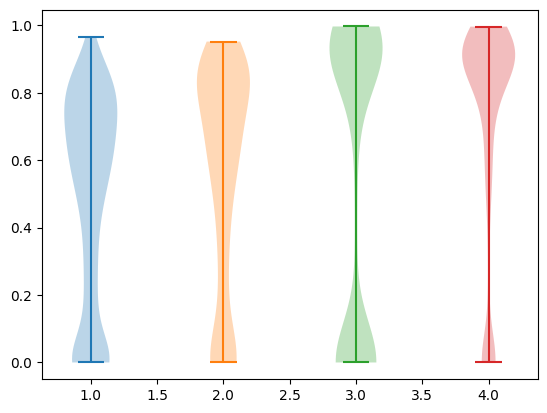

In [7]:
fig = plt.figure()
ax = fig.gca()
x = []
for i in range(1,5):
    data = dice_metrics[0, :, i]  # All samples for this class
    x.append(data)
    ax.violinplot(data[data<1], positions=[i], widths=0.4)
plt.show()

In [23]:
models = {
    'BEST_Enet': 'results/final_results/BEST/BEST_ENet',
    'BEST_UNet': 'results/final_results/BEST/BEST_UNet',
    'BEST_UNetPlusPlus': 'results/final_results/BEST/BEST_UNetPlusPlus',
    'BEST_DeepLabV3': 'results/final_results/BEST/BEST_DeepLabV3Plus',
    'BASELINE_ENet': 'results/final_results/BASELINES/BASELINE1_ENet'
}

# metrics to load
metrics = ['ahd_val.npy', 'assd_val.npy', 'dice_val.npy', 'jaccard_val.npy', 
           'loss_val.npy', 'precision_val.npy', 'recall_val.npy']

data = {}

# Looping through models and metrics, loading the .npy files, and computing the average values
for model_name, model_path in models.items():
    data[model_name] = {}
    for metric in metrics:
        metric_path = os.path.join(model_path, metric)
        # print(f"Checking: {metric_path}")
        if os.path.exists(metric_path):
            # Load the metric values from the .npy file
            metric_values = np.load(metric_path)
            
            # Determine the dimensions of the metric values
            if metric_values.ndim > 1:
                # For multi-dimensional arrays, mean across all dimensions
                average_value = np.mean(metric_values)
            else:
                # For 1D arrays, directly compute the mean
                average_value = np.mean(metric_values)
            
            data[model_name][metric.split('_')[0]] = average_value
        else:
            print(f"File not found: {metric_path}")
            data[model_name][metric.split('_')[0]] = None


df = pd.DataFrame(data).T

print(df)

                        ahd      assd      dice   jaccard      loss  \
BEST_Enet          2.503395  2.257835  0.879244  0.853688  0.038560   
BEST_UNet          3.807177  2.708745  0.862100  0.833098  0.025322   
BEST_UNetPlusPlus  3.378922  2.902328  0.884820  0.858210  0.029848   
BEST_DeepLabV3     2.758482  2.427075  0.861002  0.831472  0.024758   
BASELINE_ENet      2.682290  2.112514  0.861146  0.833327  0.033512   

                   precision    recall  
BEST_Enet           0.942652  0.889226  
BEST_UNet           0.898124  0.904568  
BEST_UNetPlusPlus   0.917320  0.920865  
BEST_DeepLabV3      0.922697  0.881772  
BASELINE_ENet       0.903413  0.903102  


In [26]:
#Pretty Printing Tables
from tabulate import tabulate 

# Convert DataFrame to a list of lists
table = [df.columns.tolist()] + df.reset_index().values.tolist()

# Print the table using tabulate with 'fancy_grid' format
pretty_table = tabulate(table, headers='firstrow', tablefmt='fancy_grid')
print(pretty_table)

╒═══════════════════╤═════════╤═════════╤══════════╤═══════════╤═══════════╤═════════════╤══════════╕
│                   │     ahd │    assd │     dice │   jaccard │      loss │   precision │   recall │
╞═══════════════════╪═════════╪═════════╪══════════╪═══════════╪═══════════╪═════════════╪══════════╡
│ BEST_Enet         │ 2.50339 │ 2.25784 │ 0.879244 │  0.853688 │ 0.0385596 │    0.942652 │ 0.889226 │
├───────────────────┼─────────┼─────────┼──────────┼───────────┼───────────┼─────────────┼──────────┤
│ BEST_UNet         │ 3.80718 │ 2.70874 │ 0.8621   │  0.833098 │ 0.025322  │    0.898124 │ 0.904568 │
├───────────────────┼─────────┼─────────┼──────────┼───────────┼───────────┼─────────────┼──────────┤
│ BEST_UNetPlusPlus │ 3.37892 │ 2.90233 │ 0.88482  │  0.85821  │ 0.0298476 │    0.91732  │ 0.920865 │
├───────────────────┼─────────┼─────────┼──────────┼───────────┼───────────┼─────────────┼──────────┤
│ BEST_DeepLabV3    │ 2.75848 │ 2.42708 │ 0.861002 │  0.831472 │ 0.0247583 │    0.

Saving the table with a white/transparent background for Presentation Purpose

In [29]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
# Create a matplotlib figure
fig = Figure(figsize=(10, 6))  # Adjust size as needed
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)

# Set white background
ax.set_facecolor("none") #or none
fig.patch.set_facecolor('none')

# Hide axes
ax.axis('off')


ax.text(0.5, 0.5, pretty_table, family='monospace', fontsize=12, ha='center', va='center', wrap=True)


fig.savefig("table_output.png", bbox_inches='tight', pad_inches=0.1)

plt.show()